In [ ]:
>>> sort out reviewS vs review .._count
>>> check out lookback windowon and reviews-based aggs
>>> get rid of unnamed and drop dupes
>>> check min days b/t inspection dates for a given restaurant
>>> decide whether to keep or drop follow up inspections

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
#import statsmodels as sm
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)

# for text analysis
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [141]:
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows',600)

## Sentiment Analysis

In [2]:
yelp_reviews_tx = pd.read_csv('yelp_reviews_tx.csv')
yelp_reviews_tx.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46
1,1,xxUbWSkZtPHrPFT_RhW68A,ZuB2N9UOIooj9nPtI3Re5g,mOnesB4IF9j6-ZmHoOHOig,2,0,0,0,I've given this place a couple of chances and ...,2014-01-17 00:55:26
2,2,48wQst-NfdRPpu32cUEsaA,AQUdnD35RBuCXNx0KxE5wA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,Definitely one of my favorite places for vietn...,2015-06-21 00:30:24
3,3,0-k1eqpn_i2FnyBBwtFSYw,IYRlxx4G8fkkc6x_gk4sPg,mOnesB4IF9j6-ZmHoOHOig,5,0,0,0,My favorite Vietnamese restaurant in town. I l...,2017-09-08 23:20:38
4,4,JF4NXGCyOgkUIQzRlQRuuw,ZYs9y2Hk_C55Ynr40TGmUA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,"Good food, good price, and good service. You ...",2010-07-07 16:27:26


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ellerybledsoe/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

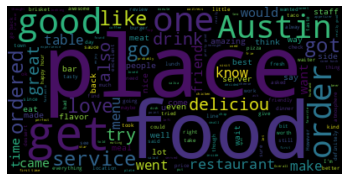

In [21]:
# Create stopword list:
#STOPWORDS = ['great','good']
#stopwords = set(STOPWORDS)
stopwords = set(stopwords.words('english'))
#stopwords.update(["br", "href"])

textt = " ".join(review for review in yelp_reviews_tx.text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [24]:
yelp_reviews_tx[['stars']].head()

,stars
0,4
1,2
2,4
3,5
4,4


In [27]:
yelp_reviews_tx['sentiment'] = yelp_reviews_tx['stars'].apply(lambda stars : +1 if stars > 3 else (0.5 if stars == 3 else 0))


In [28]:
yelp_reviews_tx[['stars','sentiment']].head()

# https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

,stars,sentiment
0,4,1.0
1,2,0.0
2,4,1.0
3,5,1.0
4,4,1.0


In [64]:
positive = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 1.0]
neutral = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 0.5]
negative = yelp_reviews_tx[yelp_reviews_tx['sentiment'] == 0.0]

In [65]:
positive['text'].head()

0    I think their rice dishes are way better than ...
2    Definitely one of my favorite places for vietn...
3    My favorite Vietnamese restaurant in town. I l...
4    Good food, good price, and good service.  You ...
5    This place is delicious! I work right down the...
Name: text, dtype: object

In [66]:
# example of a positive w/ a somewhat ambiguous interpreatation

positive['text'][0:1].values

array(["I think their rice dishes are way better than their Pho's. Also I really like their sandwiches and spring rolls. I took a friend who haven't had viennese food ever. He absolutely love it."],
      dtype=object)

In [67]:
positive['text'][1:2].values

array(['Definitely one of my favorite places for vietnamese grub! Very authentic and although they hardly speak english, the people here are really nice. Will always recommend others to try it.'],
      dtype=object)

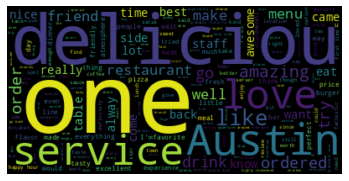

In [41]:
#stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great","place","get","got","went","food","also"]) ## good and great removed because they were included in negative sentiment

pos = " ".join(review for review in positive.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [108]:
positive = positive.assign(review_length = lambda x: (positive['text'].str.len()))
positive = positive.assign(review_word_count = lambda x: (positive['text'].str.split().str.len()))
positive['review_avg_word_length'] = positive['review_length']/positive['review_word_count']

positive.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,review_length,review_word_count,review_avg_word_length
0,0,GDgXjXSZCA1iNQWD7OHXfg,1RCRKuHgP3FskGUVnmFdxg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,I think their rice dishes are way better than ...,2017-05-26 03:05:46,1.0,187,34,5.500000
2,2,48wQst-NfdRPpu32cUEsaA,AQUdnD35RBuCXNx0KxE5wA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,Definitely one of my favorite places for vietn...,2015-06-21 00:30:24,1.0,185,30,6.166667
3,3,0-k1eqpn_i2FnyBBwtFSYw,IYRlxx4G8fkkc6x_gk4sPg,mOnesB4IF9j6-ZmHoOHOig,5,0,0,0,My favorite Vietnamese restaurant in town. I l...,2017-09-08 23:20:38,1.0,130,22,5.909091
4,4,JF4NXGCyOgkUIQzRlQRuuw,ZYs9y2Hk_C55Ynr40TGmUA,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,"Good food, good price, and good service. You ...",2010-07-07 16:27:26,1.0,240,51,4.705882
5,5,RIHq6pTxi4_36M52xB7WSA,mTij1ag3ei0E4GQHAJxN4w,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,This place is delicious! I work right down the...,2014-04-19 16:00:49,1.0,723,141,5.127660


<Figure size 864x864 with 0 Axes>

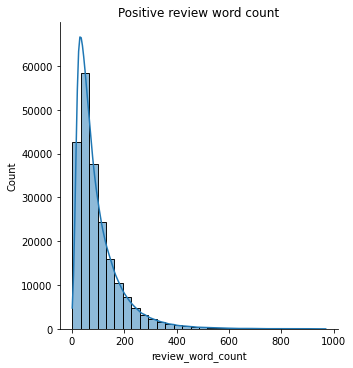

In [112]:
plt.figure(figsize = (12,12));

sns.displot(data = positive, x = 'review_word_count', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);

plt.title("Positive review word count", size = 12);

<Figure size 864x864 with 0 Axes>

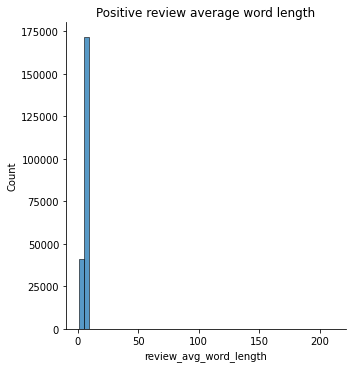

In [249]:
plt.figure(figsize = (12,12));

sns.displot(data = positive, x = 'review_avg_word_length', palette ='YlGnBu', kind = 'hist', bins = 50);

plt.title("Positive review average word length", size = 12);

In [122]:
positive['review_word_count'].mean()

97.39386470231975

In [72]:
negative['text'][3:4].values

array(["I have been to this place a couple of times and each time, I never ceased to be disappointed.  The food is sub par at best and the place is dirty.  One time a friend of mine went there and found a lizard (yes, that's right, a lizard) in his vermicelli bowl.  The service staff is not very helpful either.  They are hard to understand and always seem to be in a bad mood.  So if you enjoy paying too much for a can (yes, CAN) of soda with a cup of ice and having lizards in your food, I would recommend Pho Van."],
      dtype=object)

In [117]:
negative = negative.assign(review_length = lambda x: (negative['text'].str.len()))
negative = negative.assign(review_word_count = lambda x: (negative['text'].str.split().str.len()))
negative['review_avg_word_length'] = negative['review_length']/negative['review_word_count']

negative.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,review_length,review_word_count,review_avg_word_length
1,1,xxUbWSkZtPHrPFT_RhW68A,ZuB2N9UOIooj9nPtI3Re5g,mOnesB4IF9j6-ZmHoOHOig,2,0,0,0,I've given this place a couple of chances and ...,2014-01-17 00:55:26,0.0,551,107,5.149533
24,24,aLw25XIsnZGy3inAEyn9ug,gM99gkh-Kj7RXUCTjFEM_g,mOnesB4IF9j6-ZmHoOHOig,1,0,2,0,"We had ph, and got an accompanying veggie (bas...",2017-05-14 19:27:27,0.0,420,79,5.316456
26,26,Gy9fX3ggsl4mplirMjnWgA,kTqXUoJUkj2cttbDVjepCg,mOnesB4IF9j6-ZmHoOHOig,1,1,0,0,I came here because my usual pho place was clo...,2013-08-15 23:18:56,0.0,255,49,5.204082
46,46,CdclFI_4_K-TG7BsdSb73g,vKA60rHTPPI8-voibVt-qw,mOnesB4IF9j6-ZmHoOHOig,1,1,3,1,I have been to this place a couple of times an...,2010-01-20 22:25:12,0.0,510,104,4.903846
48,48,wM6GHbRnr8IARh43OYaQLg,f4Z7FomkhN1lj7LPycJTlQ,mOnesB4IF9j6-ZmHoOHOig,1,6,2,2,This was my first time eating here (after hear...,2010-08-24 22:41:27,0.0,1243,243,5.115226


<Figure size 864x864 with 0 Axes>

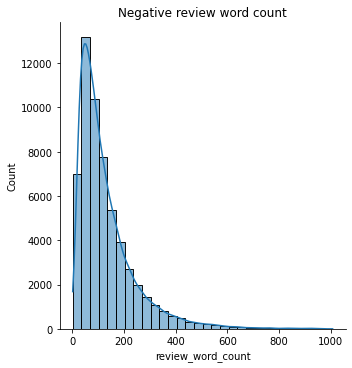

In [118]:
plt.figure(figsize = (12,12));

sns.displot(data = negative, x = 'review_word_count', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);

plt.title("Negative review word count", size = 12);

In [123]:
negative['review_word_count'].mean()

130.60305789383267

In [124]:
neutral['text'][0:1].values

array(['I hate it when people rate places based on their experiences with a competitor or like business.  I believe you should rate a business on its own merits...well I am about to break my own rule and say Pho Van is OK, even good, but compared to all the great Vietnamese places in Austin it pales in comparison.  The service I read below to be "functional".  I think that hits the nail on the head.  There are so many Vietnamese places where the Asian graciousness out shines the food.  Pho Van is adequate and I would encourage you to form your own opinion if you happen to be in the neighborhood.  The pork dishes are above average and worth a try,'],
      dtype=object)

In [125]:
neutral = neutral.assign(review_length = lambda x: (neutral['text'].str.len()))
neutral = neutral.assign(review_word_count = lambda x: (neutral['text'].str.split().str.len()))
neutral['review_avg_word_length'] = neutral['review_length']/neutral['review_word_count']

neutral.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,review_length,review_word_count,review_avg_word_length
6,6,HycmGjlRNa5PglPLKzr8NQ,v5wePigOyy2UHgbwP-iTag,mOnesB4IF9j6-ZmHoOHOig,3,0,0,0,I hate it when people rate places based on the...,2012-02-29 23:26:59,0.5,646,121,5.338843
18,18,JcymBDxe-apx74MC9FMJyg,Z0twGKkWRAgnANKlm0dkIA,mOnesB4IF9j6-ZmHoOHOig,3,0,0,2,I had the large N6 pho with very little meat. ...,2017-02-20 18:35:57,0.5,376,65,5.784615
30,30,Ve_8XuaZLXWA_4orrYtsYQ,_FHSBrOKVhJoV02mqmN8sQ,mOnesB4IF9j6-ZmHoOHOig,3,0,0,2,This food is pretty good. I wish they had more...,2015-03-05 18:42:57,0.5,162,33,4.909091
31,31,Ip4dqNTTKCPDQLxKfVx7Vw,QtDi8-TK_fNkqxBOPzRtug,mOnesB4IF9j6-ZmHoOHOig,3,0,0,0,"Pho: Overcooked noodles, fresh herbs (includes...",2012-04-30 15:21:20,0.5,136,21,6.476190
38,38,_0WlzYEP2mk7HVhMC64Vgw,CQUDh80m48xnzUkx-X5NAw,mOnesB4IF9j6-ZmHoOHOig,3,2,2,2,This was the first Pho place I knew of when I ...,2009-03-10 07:16:21,0.5,451,89,5.067416


<Figure size 864x864 with 0 Axes>

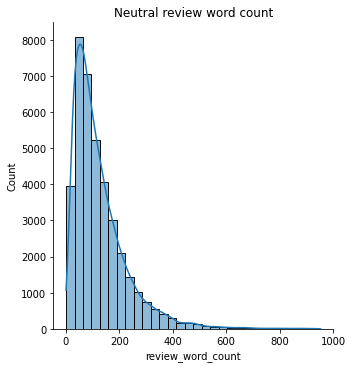

In [126]:
plt.figure(figsize = (12,12));

sns.displot(data = neutral, x = 'review_word_count', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);

plt.title("Neutral review word count", size = 12);

In [127]:
neutral['review_word_count'].mean()

126.8034964854914

In [128]:
positive.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date', 'sentiment', 'review_length',
       'review_word_count', 'review_avg_word_length'],
      dtype='object')

In [139]:
positive['text_clean'] = positive['text'].str.replace('[^a-zA-Z]', ' ')
negative['text_clean'] = negative['text'].str.replace('[^a-zA-Z]', ' ')
neutral['text_clean'] = neutral['text'].str.replace('[^a-zA-Z]', ' ')

positive['text_clean'] = positive['text_clean'].str.lower()
negative['text_clean'] = negative['text_clean'].str.lower()
neutral['text_clean'] = neutral['text_clean'].str.lower()


print(positive['text_clean'].head())

/var/folders/9p/zdxgq7zd7bbfhp_s10rpv2lm0000gn/T/ipykernel_22653/2734542005.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  positive['text_clean'] = positive['text'].str.replace('[^a-zA-Z]', ' ')
/var/folders/9p/zdxgq7zd7bbfhp_s10rpv2lm0000gn/T/ipykernel_22653/2734542005.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  negative['text_clean'] = negative['text'].str.replace('[^a-zA-Z]', ' ')
/var/folders/9p/zdxgq7zd7bbfhp_s10rpv2lm0000gn/T/ipykernel_22653/2734542005.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  neutral['text_clean'] = neutral['text'].str.replace('[^a-zA-Z]', ' ')


0    i think their rice dishes are way better than ...
2    definitely one of my favorite places for vietn...
3    my favorite vietnamese restaurant in town  i l...
4    good food  good price  and good service   you ...
5    this place is delicious  i work right down the...
Name: text_clean, dtype: object


In [135]:
cv = CountVectorizer(min_df = 0.2,max_df = 0.8)

cv.fit(positive['text_clean'])

cv_transformed = cv.fit_transform(positive['text_clean'])
cv_array = cv_transformed.toarray()
print(cv_array.shape)

(212997, 48)


In [162]:
cv.get_feature_names()[0:10]

['all', 'are', 'as', 'at', 'austin', 'back', 'be', 'best', 'but', 'can']

In [142]:
cv_df = pd.DataFrame(cv_array, columns=cv.get_feature_names()).add_prefix('Counts_')
cv_df.head()

,Counts_all,Counts_are,Counts_as,Counts_at,Counts_austin,Counts_back,Counts_be,Counts_best,Counts_but,Counts_can,Counts_delicious,Counts_food,Counts_for,Counts_get,Counts_go,Counts_good,Counts_great,Counts_had,Counts_have,Counts_here,Counts_if,Counts_in,Counts_is,Counts_it,Counts_just,Counts_like,Counts_my,Counts_not,Counts_of,Counts_on,Counts_one,Counts_out,Counts_place,Counts_service,Counts_so,Counts_that,Counts_their,Counts_there,Counts_they,Counts_this,Counts_time,Counts_to,Counts_very,Counts_was,Counts_we,Counts_were,Counts_with,Counts_you
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,1,0,1,0,2,1,3,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,2,0,0,0,0,0,4
4,0,1,0,0,0,1,0,0,0,0,4,0,2,0,0,0,0,1,1,0,1,1,4,4,0,0,2,0,3,1,1,0,2,1,0,1,1,1,2,2,0,3,0,3,0,0,0,2


In [159]:
cv_df.sum().sort_values(ascending = False)[0:10]

Counts_to      426282
Counts_was     339811
Counts_it      332020
Counts_of      320006
Counts_is      300422
Counts_for     238743
Counts_in      230574
Counts_you     186845
Counts_with    183176
Counts_but     172365
dtype: int64

In [146]:
neg_cv = CountVectorizer(min_df = 0.2,max_df = 0.8)

neg_cv.fit(negative['text_clean'])

neg_cv_transformed = neg_cv.fit_transform(negative['text_clean'])
neg_cv_array = neg_cv_transformed.toarray()
print(neg_cv_array.shape)

(58210, 65)


In [148]:
neg_cv_df = pd.DataFrame(neg_cv_array, columns=neg_cv.get_feature_names()).add_prefix('Counts_')
neg_cv_df.head(1)

,Counts_about,Counts_after,Counts_all,Counts_an,Counts_are,Counts_as,Counts_at,Counts_back,Counts_be,Counts_because,Counts_been,Counts_but,Counts_can,Counts_don,Counts_even,Counts_food,Counts_for,Counts_from,Counts_get,Counts_go,Counts_good,Counts_got,Counts_had,Counts_have,Counts_here,Counts_if,Counts_in,Counts_is,Counts_it,Counts_just,Counts_like,Counts_me,Counts_my,Counts_no,Counts_not,Counts_of,Counts_on,Counts_one,Counts_only,Counts_or,Counts_order,Counts_ordered,Counts_our,Counts_out,Counts_place,Counts_really,Counts_service,Counts_so,Counts_that,Counts_their,Counts_there,Counts_they,Counts_this,Counts_time,Counts_up,Counts_us,Counts_very,Counts_was,Counts_we,Counts_were,Counts_what,Counts_when,Counts_with,Counts_would,Counts_you
0,0,0,0,0,0,2,0,0,3,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,1,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,2,1,0,0,1,0,1,0,2,0,0,0,0,3,0,0,0,1,0,0,0


In [160]:
neg_cv_df.sum().sort_values(ascending = False)[0:10]

Counts_was     153272
Counts_it      122710
Counts_of      107593
Counts_for      88952
Counts_we       85033
Counts_that     80159
Counts_in       77666
Counts_is       69904
Counts_my       67162
Counts_but      66095
dtype: int64

In [161]:
# comparing tf-idf to cv

tv = TfidfVectorizer(max_features=100,stop_words='english')

tv_transformed = tv.fit_transform(positive['text_clean'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
tv_df.head()

,TFIDF_amazing,TFIDF_atmosphere,TFIDF_austin,TFIDF_awesome,TFIDF_bar,TFIDF_bbq,TFIDF_beef,TFIDF_beer,TFIDF_best,TFIDF_better,TFIDF_bit,TFIDF_breakfast,TFIDF_brisket,TFIDF_burger,TFIDF_came,TFIDF_cheese,TFIDF_chicken,TFIDF_coffee,TFIDF_come,TFIDF_day,TFIDF_definitely,TFIDF_delicious,TFIDF_did,TFIDF_didn,TFIDF_dinner,TFIDF_don,TFIDF_drinks,TFIDF_eat,TFIDF_excellent,TFIDF_experience,TFIDF_favorite,TFIDF_flavor,TFIDF_food,TFIDF_fresh,TFIDF_fried,TFIDF_friendly,TFIDF_friends,TFIDF_fries,TFIDF_going,TFIDF_good,TFIDF_got,TFIDF_great,TFIDF_happy,TFIDF_hot,TFIDF_hour,TFIDF_just,TFIDF_know,TFIDF_like,TFIDF_line,TFIDF_little,TFIDF_ll,TFIDF_location,TFIDF_lot,TFIDF_love,TFIDF_loved,TFIDF_lunch,TFIDF_make,TFIDF_meal,TFIDF_meat,TFIDF_menu,TFIDF_new,TFIDF_nice,TFIDF_night,TFIDF_order,TFIDF_ordered,TFIDF_parking,TFIDF_people,TFIDF_perfect,TFIDF_pizza,TFIDF_place,TFIDF_pork,TFIDF_pretty,TFIDF_really,TFIDF_recommend,TFIDF_restaurant,TFIDF_right,TFIDF_salad,TFIDF_sauce,TFIDF_say,TFIDF_service,TFIDF_small,TFIDF_spicy,TFIDF_spot,TFIDF_staff,TFIDF_super,TFIDF_sure,TFIDF_sweet,TFIDF_table,TFIDF_tacos,TFIDF_tasty,TFIDF_think,TFIDF_time,TFIDF_tried,TFIDF_try,TFIDF_ve,TFIDF_wait,TFIDF_want,TFIDF_way,TFIDF_went,TFIDF_worth
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.447883,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.233466,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.316947,0.0,0.000000,0.0,0.0,0.0,0.346366,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.333725,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.453302,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.455647,0.00000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.359749,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400664,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.361737,0.0,0.000000,0.000000,0.0,0.413021,0.0,0.0,0.000000,0.000000,0.000000,0.323865,0.413327,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.364529,0.00000,0.0,0.0,0.000000,0.00000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.466444,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.391317,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.452289,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.520917,0.000000,0.39164,0.0,0.0,0.000000,0.00000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.203567,0.0,0.0,0.000000,0.0,0.0,0.0,0.645824,0.0,0.0,0.0,0.0,0.0,0.0,0.394543,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.347517,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.266183,0.000000,0.0,0.0,0.336901,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.284048,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.00000,0.0
4,0.0,0.0,0.0,0.143559,0.0,0.160985,0.0,0.0,0.0,0.000000,0.151795,0.0,0.158472,0.0,0.0,0.0,0.0,0.0,0.135755,0.148679,0.000000,0.432557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.123724,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.128596,0.0,0.0,0.

In [183]:
tv_df.sum().sort_values(ascending = False).head(10)

TFIDF_great        19946.085064
TFIDF_food         19624.499028
TFIDF_good         18698.367118
TFIDF_place        17646.895782
TFIDF_service      12303.039655
TFIDF_austin       11952.524994
TFIDF_delicious    11043.537426
TFIDF_love         11011.263830
TFIDF_best         10978.262441
TFIDF_like         10956.215728
dtype: float64

In [164]:
# comparing tf-idf to cv

neg_tv = TfidfVectorizer(max_features=100,stop_words='english')

neg_tv_transformed = neg_tv.fit_transform(negative['text_clean'])

# Create a DataFrame with these features
neg_tv_df = pd.DataFrame(neg_tv_transformed.toarray(), 
                     columns=neg_tv.get_feature_names()).add_prefix('TFIDF_')
neg_tv_df.head()

,TFIDF_ask,TFIDF_asked,TFIDF_austin,TFIDF_away,TFIDF_bad,TFIDF_bar,TFIDF_best,TFIDF_better,TFIDF_bland,TFIDF_burger,TFIDF_came,TFIDF_check,TFIDF_cheese,TFIDF_chicken,TFIDF_cold,TFIDF_come,TFIDF_customer,TFIDF_day,TFIDF_did,TFIDF_didn,TFIDF_dinner,TFIDF_disappointed,TFIDF_don,TFIDF_drink,TFIDF_drinks,TFIDF_eat,TFIDF_experience,TFIDF_finally,TFIDF_flavor,TFIDF_food,TFIDF_friend,TFIDF_going,TFIDF_good,TFIDF_got,TFIDF_great,TFIDF_hour,TFIDF_just,TFIDF_know,TFIDF_left,TFIDF_like,TFIDF_little,TFIDF_ll,TFIDF_location,TFIDF_long,TFIDF_love,TFIDF_lunch,TFIDF_make,TFIDF_manager,TFIDF_maybe,TFIDF_meal,TFIDF_meat,TFIDF_menu,TFIDF_minutes,TFIDF_nice,TFIDF_night,TFIDF_ok,TFIDF_order,TFIDF_ordered,TFIDF_people,TFIDF_pizza,TFIDF_place,TFIDF_pretty,TFIDF_really,TFIDF_restaurant,TFIDF_right,TFIDF_rude,TFIDF_said,TFIDF_salad,TFIDF_sauce,TFIDF_say,TFIDF_server,TFIDF_service,TFIDF_small,TFIDF_staff,TFIDF_sure,TFIDF_table,TFIDF_tacos,TFIDF_taste,TFIDF_tasted,TFIDF_terrible,TFIDF_thing,TFIDF_think,TFIDF_time,TFIDF_times,TFIDF_told,TFIDF_took,TFIDF_tried,TFIDF_try,TFIDF_ve,TFIDF_wait,TFIDF_waited,TFIDF_waiter,TFIDF_waiting,TFIDF_waitress,TFIDF_want,TFIDF_wanted,TFIDF_wasn,TFIDF_way,TFIDF_went,TFIDF_worst
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.348875,0.0,0.000000,0.0,0.000000,0.000000,0.148385,0.0,0.187582,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.20104,0.0,0.0,0.0,0.000000,0.0,0.791711,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.218515,0.000000,0.142644,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.180845,0.000000,0.0,0.0,0.0,0.150884,0.0,0.0,0.0,0.0,0.0,0.174045,0.0,0.0,0.000000,0.00000,0.0
1,0.245341,0.198942,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.203115,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.170193,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.697082,0.0,0.0,0.000000,0.0,0.224344,0.0,0.0,0.235325,0.0,0.0,0.00000,0.0,0.0,0.0,0.235366,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.168666,0.0,0.0,0.0,0.000000,0.000000,0.175913,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.230744,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.155801,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.214638,0.0,0.0,0.000000,0.00000,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.426095,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.255731,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.320077,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.308850,0.000000,0.000000,0.000000,0.000000,0.563094,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.487987,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0
3,0.000000,0.000000,0.0,0.0,0.244604,0.0,0.294861,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.288748,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.278513,0.325511,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.336365,0.000000,0.000000,0.000000,0.284602,0.000000,0.0,0.0,0.0,0.000000,0.0,0.178167,0.0,0.272485,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.388941,0.278378,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.23963,0.0
4,0.000000,0.591476,0.0,0.0,0.145657,0.0,0.000000,0.0,0.0,0.0,0.138168,0.0,0.0,0.000000,0.0,0.000000,0.0,0.178519,0.293682,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.165849,0.000000,0.0,0.105323,0.000000,0.0,0.0,0.103790,0.0,0.166749,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.10

In [182]:
neg_tv_df.sum().sort_values(ascending = False).head(10)

TFIDF_food       6498.568793
TFIDF_place      4670.937389
TFIDF_good       4238.945721
TFIDF_just       4079.213464
TFIDF_service    4049.127599
TFIDF_like       4034.188249
TFIDF_time       3348.668000
TFIDF_order      3299.053583
TFIDF_ordered    2879.835825
TFIDF_don        2845.949651
dtype: float64

In [168]:
tv_df.iloc[0].sort_values(ascending = False).head()

TFIDF_way       0.455647
TFIDF_think     0.453302
TFIDF_better    0.447883
TFIDF_love      0.346366
TFIDF_really    0.333725
Name: 0, dtype: float64

In [167]:
neg_tv_df.iloc[0].sort_values(ascending = False).head()

TFIDF_meat            0.791711
TFIDF_chicken         0.348875
TFIDF_place           0.218515
TFIDF_love            0.201040
TFIDF_disappointed    0.187582
Name: 0, dtype: float64

In [169]:
# building some ngrams

cv_bigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range = (2,2))

# Fit and apply trigram vectorizer
cv_bigram = cv_bigram_vec.fit_transform(positive['text_clean'])

# Print the trigram features
print(cv_bigram_vec.get_feature_names())

# https://campus.datacamp.com/courses/feature-engineering-for-machine-learning-in-python/dealing-with-text-data?ex=15

['amazing food', 'bbq sauce', 'beef rib', 'beef ribs', 'beer selection', 'best bbq', 'best ve', 'breakfast tacos', 'chicken fried', 'chips salsa', 'coffee shop', 'customer service', 'date night', 'definitely come', 'definitely recommend', 'definitely worth', 'delicious food', 'dim sum', 'dining experience', 'don know', 'don like', 'don think', 'excellent service', 'fast food', 'feel like', 'felt like', 'food amazing', 'food came', 'food delicious', 'food drinks', 'food excellent', 'food good', 'food great', 'food really', 'food service', 'french toast', 'fried chicken', 'fried rice', 'friendly helpful', 'friendly service', 'friendly staff', 'gluten free', 'good food', 'good place', 'good service', 'great atmosphere', 'great experience', 'great food', 'great place', 'great service', 'great time', 'green beans', 'happy hour', 'highly recommend', 'ice cream', 'just good', 'just right', 'late night', 'little bit', 'live music', 'll definitely', 'long time', 'love love', 'love place', 'mac 

In [172]:
cv_bi_df = pd.DataFrame(cv_bigram.toarray(), columns=cv_bigram_vec.get_feature_names()).add_prefix('Counts_')

print(cv_bi_df.sum().sort_values(ascending=False).head())

Counts_happy hour          11496
Counts_really good          9923
Counts_highly recommend     8032
Counts_great food           7661
Counts_great place          7500
dtype: int64


In [170]:
# building some ngrams

cv_trigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range = (3,3))

# Fit and apply trigram vectorizer
cv_trigram = cv_trigram_vec.fit_transform(positive['text_clean'])

# Print the trigram features
print(cv_trigram_vec.get_feature_names())

['absolutely love place', 'amy ice cream', 'authentic mexican food', 'beef noodle soup', 'best bbq ve', 'best breakfast tacos', 'best brisket ve', 'best fried chicken', 'best mexican food', 'best ve austin', 'breakfast lunch dinner', 'brisket pork ribs', 'brisket pulled pork', 'cake french toast', 'carrot cake french', 'chicken fried chicken', 'chicken fried steak', 'chicken tikka masala', 'customer service great', 'definitely recommend place', 'delicious highly recommend', 'did great job', 'don feel like', 'duck fat fries', 'extra moist brisket', 'favorite places austin', 'favorite places eat', 'favorite restaurant austin', 'favorite restaurants austin', 'fonda san miguel', 'food came quickly', 'food excellent service', 'food good service', 'food great atmosphere', 'food great service', 'food pretty good', 'food really good', 'food service great', 'fried green tomatoes', 'friendly staff great', 'gluten free options', 'good beer selection', 'good food good', 'good food great', 'good ha

In [181]:
cv_tri_df = pd.DataFrame(cv_trigram.toarray(), columns=cv_trigram_vec.get_feature_names()).add_prefix('pos_trigram_')

print(cv_tri_df.sum().sort_values(ascending=False).head(20))

pos_trigram_great food great          1237
pos_trigram_food great service        1140
pos_trigram_highly recommend place     989
pos_trigram_staff super friendly       974
pos_trigram_chicken fried steak        961
pos_trigram_service great food         948
pos_trigram_love love love             947
pos_trigram_sweet potato fries         921
pos_trigram_food really good           754
pos_trigram_great happy hour           727
pos_trigram_duck fat fries             703
pos_trigram_great service great        685
pos_trigram_great customer service     682
pos_trigram_happy hour menu            639
pos_trigram_good food good             606
pos_trigram_food pretty good           571
pos_trigram_food good service          543
pos_trigram_fried green tomatoes       514
pos_trigram_indoor outdoor seating     511
pos_trigram_really really good         509
dtype: int64


In [173]:
# building some ngrams

neg_cv_bigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range = (2,2))

# Fit and apply trigram vectorizer
neg_cv_bigram = neg_cv_bigram_vec.fit_transform(negative['text_clean'])

# Print the trigram features
print(neg_cv_bigram_vec.get_feature_names())

['asked wanted', 'bad service', 'big deal', 'breakfast tacos', 'chicken fried', 'chips salsa', 'credit card', 'customer service', 'decided try', 'didn know', 'didn want', 'dining experience', 'don care', 'don know', 'don like', 'don think', 'don want', 'drink order', 'excited try', 'fast food', 'feel like', 'felt like', 'finally got', 'food came', 'food drinks', 'food good', 'food great', 'food just', 'food mediocre', 'food ok', 'food poisoning', 'food service', 'fried chicken', 'gluten free', 'good food', 'good service', 'good thing', 'got food', 'great food', 'happy hour', 'horrible service', 'ice cream', 'just don', 'just ok', 'let know', 'like place', 'long time', 'long wait', 'looked like', 'looking forward', 'looks like', 'love place', 'mac cheese', 'make sure', 'maybe just', 'mediocre best', 'mexican food', 'minute wait', 'minutes later', 'needless say', 'order food', 'order wrong', 'ordered chicken', 'ordered food', 'pad thai', 'parking lot', 'place just', 'place order', 'place

In [174]:
neg_cv_bi_df = pd.DataFrame(neg_cv_bigram.toarray(), columns=neg_cv_bigram_vec.get_feature_names()).add_prefix('Counts_')

print(neg_cv_bi_df.sum().sort_values(ascending=False).head())

Counts_customer service    3335
Counts_tasted like         2702
Counts_don know            2283
Counts_food good           2125
Counts_happy hour          1784
dtype: int64


In [175]:
# building some ngrams

neg_cv_trigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range = (3,3))

# Fit and apply trigram vectorizer
neg_cv_trigram = neg_cv_trigram_vec.fit_transform(negative['text_clean'])

# Print the trigram features
print(neg_cv_trigram_vec.get_feature_names())

['actually pretty good', 'asked speak manager', 'bad customer service', 'bad taste mouth', 'came minutes later', 'chicken fried chicken', 'chicken fried steak', 'chicken tikka masala', 'customer service skills', 'decided try place', 'didn feel like', 'didn taste like', 'don know happened', 'don know place', 'don think ll', 'don waste money', 'don waste time', 'egg drop soup', 'excited try place', 'fast food restaurant', 'food bad service', 'food good service', 'food great service', 'food just ok', 'food just okay', 'food mediocre best', 'food pretty good', 'food really good', 'food sub par', 'food terrible service', 'food took forever', 'food wasn bad', 'food wasn good', 'good customer service', 'good food good', 'good mexican food', 'good tex mex', 'good thing place', 'got food poisoning', 'got order wrong', 'great customer service', 'happy hour menu', 'happy hour prices', 'hard earned money', 'having bad day', 'heard good things', 'heard great things', 'high hopes place', 'horrible c

In [177]:
neg_cv_tri_df = pd.DataFrame(neg_cv_trigram.toarray(), columns=neg_cv_trigram_vec.get_feature_names()).add_prefix('Counts_')

print(neg_cv_tri_df.sum().sort_values(ascending=False).head(10))

Counts_chicken fried steak      363
Counts_really wanted like       334
Counts_don waste time           329
Counts_wanted like place        320
Counts_don think ll             310
Counts_food good service        237
Counts_waste time money         224
Counts_food mediocre best       217
Counts_poor customer service    214
Counts_food pretty good         208
dtype: int64


In [185]:
frames = [positive,neutral,negative]

print(positive.shape)
print(neutral.shape)
print(negative.shape)

sentiment_df = pd.concat(frames,axis=0)
sentiment_df.head()

print(sentiment_df.shape)

(212997, 15)
(38839, 15)
(58210, 15)
(310046, 15)


In [188]:
sentiment_cv_trigram = cv_trigram_vec.transform(sentiment_df['text_clean'])

# Print the trigram features
# print(cv_trigram_vec.get_feature_names())

In [210]:
sentiment_cv_tri_df = pd.DataFrame(sentiment_cv_trigram.toarray(), columns=cv_trigram_vec.get_feature_names()).add_prefix('pos_trigram_')

print(sentiment_cv_tri_df.sum().sort_values(ascending=False).head(10))

trigram_cols_lst = sentiment_cv_tri_df.sum().sort_values(ascending=False).head(10).index.tolist()

pos_trigram_chicken fried steak       1631
pos_trigram_food great service        1355
pos_trigram_great food great          1316
pos_trigram_sweet potato fries        1262
pos_trigram_food pretty good          1181
pos_trigram_service great food        1130
pos_trigram_staff super friendly      1055
pos_trigram_love love love            1020
pos_trigram_highly recommend place    1008
pos_trigram_food really good          1006
dtype: int64


In [225]:
sentiment_df_00 = pd.concat([sentiment_df,sentiment_cv_tri_df[trigram_cols_lst]], axis = 1)
print(sentiment_df_00.shape)

(310046, 25)


In [226]:
sentiment_df_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310046 entries, 0 to 310045
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Unnamed: 0                          310046 non-null  int64  
 1   review_id                           310046 non-null  object 
 2   user_id                             310046 non-null  object 
 3   business_id                         310046 non-null  object 
 4   stars                               310046 non-null  int64  
 5   useful                              310046 non-null  int64  
 6   funny                               310046 non-null  int64  
 7   cool                                310046 non-null  int64  
 8   text                                310046 non-null  object 
 9   date                                310046 non-null  object 
 10  sentiment                           310046 non-null  float64
 11  review_length             

In [227]:
print(sentiment_df_00.shape)
sentiment_df_00 = sentiment_df_00.drop(columns = ['Unnamed: 0'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['sentiment']) # removing as this was an intermediate construct based on stars to split the data for feature building
sentiment_df_00 = sentiment_df_00.drop(columns = ['text'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['text_clean'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['user_id'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['stars'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['useful'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['funny'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['cool'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['pos_trigram_chicken fried steak'])
sentiment_df_00 = sentiment_df_00.drop(columns = ['pos_trigram_sweet potato fries'])

print(sentiment_df_00.shape)

(310046, 25)
(310046, 14)


In [228]:
sentiment_df_00['date_trim'] = pd.to_datetime(sentiment_df_00['date']).dt.date
del sentiment_df_00['date']
print(sentiment_df_00.shape)

(310046, 14)


In [231]:
# function to do multiple aggregations that will flatten the data

def flatten(x):
    d = {}
    #d['reviews_count'] = x['review_id'].count()
    #d['useful_sum'] = x['useful'].sum()
    #d['funny_sum'] = x['funny'].sum()
    #d['cool_sum'] = x['cool'].sum()
    #d['stars_1.0_sum'] = x['stars_1.0'].sum()
    #d['stars_2.0_sum'] = x['stars_2.0'].sum()
    #d['stars_3.0_sum'] = x['stars_3.0'].sum()
    #d['stars_4.0_sum'] = x['stars_4.0'].sum()
    #d['stars_5.0_sum'] = x['stars_5.0'].sum()
    #d['stars_nan_sum'] = x['stars_nan'].sum()
    # adding sentiment analysis aggs 
    d['review_length'] = x['review_length'].median()
    d['review_word_count'] = x['review_word_count'].median()
    d['pos_trigram_food great service'] = x['pos_trigram_food great service'].sum()
    d['pos_trigram_great food great'] = x['pos_trigram_great food great'].sum()
    d['pos_trigram_food pretty good'] = x['pos_trigram_food pretty good'].sum()
    d['pos_trigram_service great food'] = x['pos_trigram_service great food'].sum()
    d['staff super friendly'] = x['pos_trigram_staff super friendly'].sum()
    d['pos_trigram_love love love'] = x['pos_trigram_love love love'].sum()
    d['pos_trigram_highly recommend place'] = x['pos_trigram_highly recommend place'].sum()
    d['pos_trigram_food really good'] = x['pos_trigram_food really good'].sum()
    
    return pd.Series(d, index=[#'reviews_count', 'useful_sum', 'funny_sum', 'cool_sum','stars_1.0_sum','stars_2.0_sum','stars_3.0_sum','stars_4.0_sum','stars_5.0_sum','stars_nan_sum'\
                              'review_length',
                              'review_word_count',
                              'pos_trigram_food great service',
                              'pos_trigram_great food great',
                              'pos_trigram_food pretty good',
                              'pos_trigram_service great food',
                              'pos_trigram_staff super friendly',
                              'pos_trigram_love love love',
                              'pos_trigram_highly recommend place',
                              'pos_trigram_food really good'])


# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/53096340

In [232]:
# flattening sentiment analysis data 
# ** takes ~7 minutes to run **

import time

start = time.time()

print(sentiment_df_00.business_id.nunique())
sentiment_df_01 = sentiment_df_00.groupby(['business_id', 'date_trim']).apply(flatten)
sentiment_df_01 = sentiment_df_01.reset_index()
print(sentiment_df_01.shape)
print("runtime: ", time.time() - start)
sentiment_df_01.head()


1141
(267288, 12)
runtime:  -422.41416788101196


,business_id,date_trim,review_length,review_word_count,pos_trigram_food great service,pos_trigram_great food great,pos_trigram_food pretty good,pos_trigram_service great food,pos_trigram_staff super friendly,pos_trigram_love love love,pos_trigram_highly recommend place,pos_trigram_food really good
0,-4ofMtrD7pSpZIX5pnDkig,2005-09-10,314.0,54.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
1,-4ofMtrD7pSpZIX5pnDkig,2006-01-09,344.0,67.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2,-4ofMtrD7pSpZIX5pnDkig,2006-03-04,269.0,49.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
3,-4ofMtrD7pSpZIX5pnDkig,2006-04-19,245.0,41.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
4,-4ofMtrD7pSpZIX5pnDkig,2006-08-08,190.0,35.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [233]:
sentiment_df_02 = sentiment_df_01.reset_index()
del sentiment_df_02['index']
print('number of unique restaurants: ',sentiment_df_02.business_id.nunique())

number of unique restaurants:  1141


In [ ]:
#>>> drop sentiment column from final ads
>>> drop avg word length column from final ads
>>> drop duplicate scores on some day

## A bit of additional grooming on base dataset

In [57]:
full_dataset = pd.read_csv('austin_restaurant_inspections_full_dataset.csv')
full_dataset.head()

,Unnamed: 0,Restaurant Name,Zip Code,Inspection Date,Facility ID,Process Description,letter_grade,addr_line_1,business_id,latitude,...,video,friday,monday,saturday,sunday,thursday,tuesday,wednesday,pass_fail_flag,rest_plus_inspection_date
0,0,CASINO EL CAMINO,78701,2018-08-13,2800956.0,Routine Inspection,C,517 E 6TH ST,KjaK4CsJ_PypmVBncLwWAA,77606 30.264840\n56196 30.266555\n5694...,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,CASINO EL CAMINO | 2018-08-13
1,1,HOFFBRAU,78701,2018-08-13,2800453.0,Routine Inspection,A,613 W 6TH ST,ECoWKQReWHmkmChoQp2MrQ,77606 30.264840\n56196 30.266555\n5694...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,HOFFBRAU | 2018-08-13
2,2,WALTON'S FANCY & STAPLE,78701,2018-08-13,10196030.0,Routine Inspection,B,609 W 6TH ST,iyeJrTWE3_Xtup77dC_Mtg,77606 30.264840\n56196 30.266555\n5694...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,WALTON'S FANCY & STAPLE | 2018-08-13
3,3,WU CHOW,78701,2018-08-13,11427856.0,Routine Inspection,C,500 W 5TH ST,nyDs0CD-lFysI3oIG9T5bw,77606 30.264840\n56196 30.266555\n5694...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,WU CHOW | 2018-08-13
4,4,MCDONALD'S,78704,2018-08-13,2801718.0,Routine Inspection,A,3909 S CONGRESS AVE,MQPWdkf6wTNtdiHUu-e-OA,77606 30.264840\n56196 30.266555\n5694...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,MCDONALD'S | 2018-08-13


In [58]:
print(full_dataset.shape)
full_dataset = full_dataset.drop(columns=['Unnamed: 0','review_count'])
print(full_dataset.shape)

(5960, 267)
(5960, 265)


In [59]:
# dropping follow-up inspections

print(full_dataset.shape)
full_dataset = full_dataset[full_dataset['Process Description'] == 'Routine Inspection']
print(full_dataset.shape)

(5960, 265)
(5868, 265)


## Joining sentiment analysis columns

In [61]:
# trimming some columns
del positive['user_id']
del positive['text']
positive.head(1)

,Unnamed: 0,review_id,business_id,stars,useful,funny,cool,date,sentiment
0,0,GDgXjXSZCA1iNQWD7OHXfg,mOnesB4IF9j6-ZmHoOHOig,4,0,0,0,2017-05-26 03:05:46,1.0


In [239]:
# converting Inspection Date column to datetime64 to support appropriate sorting for loop

full_dataset_00 = full_dataset.copy()
full_dataset_00['Inspection Date'] = pd.to_datetime(full_dataset_00['Inspection Date'])
#full_dataset_00.head()

In [240]:
count = 0
#prior_date = dt.strptime('2017-10-17', "%Y-%m-%d").date()  # inspections to be roughly quarterly, thus allowing a 2-month lag for first set of yelp reviews
prior_date = dt.date(full_dataset_00['Inspection Date'].min() - np.timedelta64(60,'D'))
loop_out = pd.DataFrame()

start = time.time()

for date in pd.Series(full_dataset_00['Inspection Date'].unique()).sort_values():
#for date in pd.Series(austin_inspections_yelp_merge4['Inspection Date'].unique()).sort_values().head(1): # QA    
    #print('prior date: ',prior_date)
    #print('date: ',dt.date(date))
    #print(date)
    loop_inspections = full_dataset_00.loc[full_dataset_00['Inspection Date'].astype(str)==str(dt.date(date))] # filtering down to specific inspection date
    #print(loop_inspections.shape)
    loop_reviews = sentiment_df_02.loc[(sentiment_df_02['date_trim'] <= dt.date(date)) & (sentiment_df_02['date_trim'] > prior_date)] # filtering reviews down to those that precede the inspection date
    #print(loop_reviews.shape)
    del loop_reviews['date_trim'] # dropping date column from reviews in order to rollup counts
    loop_reviews = loop_reviews.groupby(by=['business_id']).sum().reset_index() # rolling up review counts
    loop_inspections_reviews_merge = loop_inspections.merge(loop_reviews,how='left', on='business_id') # joining inspections and preceding review totals
    loop_out = pd.concat([loop_out,loop_inspections_reviews_merge])
    #print(loop_out.shape)
    if count%100 == 0:
        print(loop_out.shape)
    
    prior_date = dt.date(date - np.timedelta64(60,'D'))
    count+=1

full_dataset_00 = pd.DataFrame(loop_out)

print("runtime: ", time.time() - start)
print(full_dataset_00.shape)
full_dataset_00.head()



(14, 275)
(728, 275)
(1469, 275)
(2445, 275)
(3348, 275)
(4189, 275)
(4843, 275)
(5646, 275)
runtime:  53.234760999679565
(5868, 275)


,Restaurant Name,Zip Code,Inspection Date,Facility ID,Process Description,letter_grade,addr_line_1,business_id,latitude,longitude,converted_date,month_year,reviews_count,useful_sum,funny_sum,cool_sum,stars_1.0_sum,stars_2.0_sum,stars_3.0_sum,stars_4.0_sum,stars_5.0_sum,stars_nan_sum,stars,is_open,Score,Active Life,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bagels,Bakeries,Barbeque,Bars,Beauty & Spas,Beer,Beer Bar,Breakfast & Brunch,Breweries,Bubble Tea,Buffets,Burgers,Cafes,Cajun/Creole,Caterers,Chicken Shop,Chicken Wings,Chinese,Cocktail Bars,Coffee & Tea,Comfort Food,Convenience Stores,Cooking Schools,Cosmetics & Beauty Supply,Delis,Desserts,Dim Sum,Diners,Dive Bars,Education,Event Planning & Services,Fast Food,Florists,Flowers & Gifts,Food,Food Court,Food Delivery Services,Food Stands,Food Trucks,French,Fruits & Veggies,Gastropubs,Gluten-Free,Greek,Grocery,Halal,Health Markets,Home Services,Hot Dogs,Hotels,Hotels & Travel,Ice Cream & Frozen Yogurt,Indian,Italian,Japanese,Juice Bars & Smoothies,Korean,Latin American,Local Flavor,Local Services,Lounges,Meat Shops,Mediterranean,Mexican,Middle Eastern,Music Venues,Nightlife,Party & Event Planning,Pizza,Pubs,Restaurants,Salad,Sandwiches,Seafood,Shopping,Shopping Centers,Soul Food,Soup,Southern,Specialty Food,Specialty Schools,Sports Bars,Steakhouses,Sushi Bars,Tacos,Tapas/Small Plates,Tex-Mex,Thai,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Wine & Spirits,HasTV,ByAppointmentOnly,RestaurantsTableService,DogsAllowed,HappyHour,DriveThru,WheelchairAccessible,RestaurantsDelivery,RestaurantsTakeOut,Caters,RestaurantsReservations,CoatCheck,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,Corkage,GoodForKids,BYOBCorkage,BusinessAcceptsBitcoin,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForDancing,BYOB,Open24Hours,DietaryRestrictions,RestaurantsCounterService,AcceptsInsurance,Zip Code_78617,Zip Code_78620,Zip Code_78653,Zip Code_78660,Zip Code_78701,Zip Code_78702,Zip Code_78703,Zip Code_78704,Zip Code_78705,Zip Code_78719,Zip Code_78721,Zip Code_78722,Zip Code_78723,Zip Code_78724,Zip Code_78726,Zip Code_78727,Zip Code_78728,Zip Code_78729,Zip Code_78730,Zip Code_78731,Zip Code_78732,Zip Code_78733,Zip Code_78734,Zip Code_78735,Zip Code_78736,Zip Code_78738,Zip Code_78741,Zip Code_78744,Zip Code_78745,Zip Code_78746,Zip Code_78748,Zip Code_78749,Zip Code_78750,Zip Code_78751,Zip Code_78752,Zip Code_78753,Zip Code_78754,Zip Code_78756,Zip Code_78757,Zip Code_78758,Zip Code_78759,Zip Code_nan,Alcohol_0,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',Alcohol_nan,WiFi_0,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_u'free',WiFi_u'no',WiFi_nan,RestaurantsAttire_0,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_nan,NoiseLevel_0,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',NoiseLevel_nan,Smoking_0,Smoking_'no',Smoking_u'no',Smoking_u'outdoor',Smoking_u'yes',Smoking_nan,garage,lot,street,valet,validated,breakfast,brunch,dessert,dinner,latenight,lunch,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale,background_music,dj,jukebox,karaoke,live,no_music,video,friday,monday,saturday,sunday,thursday,tuesday,wednesday,pass_fail_flag,rest_plus_inspection_date,review_length,review_word_count,pos_trigram_food great service,pos_trigram_great food great,pos_trigram_food pretty good,pos_trigram_service great food,pos_trigram_staff super friendly,pos_trigram_love love love,pos_trigram_highly recommend place,pos_trigram_food really good
0,CASINO EL CAMINO,78701,2018-08-13,2800956.0,Routine Inspection,C,517 E 6TH ST,KjaK4CsJ_PypmVBncLwWAA,77606 30.264840\n56196 30.266555\n5694...,77606 -97.730867\n56196 -97.733032\n5694...,2018-08-13,2018-08-01,13.0,10.0,12.0,13.0,2.0,1.0,0.0,5.0,5.0,

In [241]:
# exporting some data

full_dataset_00.to_csv('austin_full_dataset_00.csv')

## Building time-based features

In [280]:
full_dataset_00 = full_dataset_00.reset_index(drop=True)
full_dataset_00['month_year'] = pd.to_datetime(full_dataset_00['month_year'])
full_dataset_01 = full_dataset_00.copy()

In [287]:
#full_dataset_01[full_dataset_01.Score.isna() == True]
#full_dataset_01.month_year.head()

In [286]:
#full_dataset_00.dtypes

In [298]:
###pd.options.mode.chained_assignment = None 
###
###lag_scores = full_dataset_01[['Restaurant Name','Zip Code','Facility ID','month_year','Score']]
###lag_scores['ts_rank'] = lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID'])['month_year'].rank(method='dense')
###lag_scores['lag1_score'] = lag_scores.sort_values(by=['month_year'], ascending=True)\
###                        .groupby(['Restaurant Name','Zip Code','Facility ID'])['Score'].shift(1)
###lag_scores['lag2_score'] = lag_scores.sort_values(by=['month_year'], ascending=True)\
###                        .groupby(['Restaurant Name','Zip Code','Facility ID'])['Score'].shift(2)
###
###lag_scores = lag_scores.sort_values(by=['Restaurant Name','Zip Code','Facility ID','month_year'],ascending=True).reset_index(drop=True)
###
###lag_scores['oldest_score'] = lag_scores['Score'].loc[lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID'])['month_year'].rank(method ='first') == 1]
###lag_scores['oldest_score'] = lag_scores['oldest_score'].ffill(axis=0)
###
###lag_scores['newest_score'] = lag_scores['Score'].loc[lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID'])['month_year'].rank(method ='first', ascending = False) == 1]
###lag_scores['newest_score'] = lag_scores['newest_score'].bfill(axis=0)
###
###    
####lag_scores.sort_values(by=['Restaurant Name','Zip Code','month_year'],ascending=True).head(20)
###lag_scores.head()

In [290]:
#lag_scores.info()

In [296]:
pd.options.mode.chained_assignment = None 

lag_scores = full_dataset_01[['Restaurant Name','Zip Code','Facility ID','business_id','month_year','Score']]
lag_scores['ts_rank'] = lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID','business_id'])['month_year'].rank(method='dense')
lag_scores['lag1_score'] = lag_scores.sort_values(by=['month_year'], ascending=True)\
                        .groupby(['Restaurant Name','Zip Code','Facility ID','business_id'])['Score'].shift(1)
lag_scores['lag2_score'] = lag_scores.sort_values(by=['month_year'], ascending=True)\
                        .groupby(['Restaurant Name','Zip Code','Facility ID','business_id'])['Score'].shift(2)

lag_scores = lag_scores.sort_values(by=['Restaurant Name','Zip Code','Facility ID','month_year'],ascending=True).reset_index(drop=True)

lag_scores['oldest_score'] = lag_scores['Score'].loc[lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID','business_id'])['month_year'].rank(method ='first') == 1]
lag_scores['oldest_score'] = lag_scores['oldest_score'].ffill(axis=0)

lag_scores['newest_score'] = lag_scores['Score'].loc[lag_scores.groupby(['Restaurant Name','Zip Code','Facility ID','business_id'])['month_year'].rank(method ='first', ascending = False) == 1]
lag_scores['newest_score'] = lag_scores['newest_score'].bfill(axis=0)

    
#lag_scores.sort_values(by=['Restaurant Name','Zip Code','month_year'],ascending=True).head(20)
lag_scores.head()

,Restaurant Name,Zip Code,Facility ID,business_id,month_year,Score,ts_rank,lag1_score,lag2_score,oldest_score,newest_score
0,15TH STREET CAFE,78701,2801033.0,FwO183blfDg8g6sFv-NTsQ,2019-01-01,91.0,1.0,NaN,NaN,91.0,92.0
1,15TH STREET CAFE,78701,2801033.0,FwO183blfDg8g6sFv-NTsQ,2019-08-01,94.0,2.0,91.0,NaN,91.0,92.0
2,15TH STREET CAFE,78701,2801033.0,FwO183blfDg8g6sFv-NTsQ,2021-07-01,92.0,3.0,94.0,91.0,91.0,92.0
3,2 N 1 SALAD BAR AND GRILL,78758,11534776.0,1tepUnoMCFEVMNE26ijYRQ,2019-03-01,90.0,1.0,NaN,NaN,90.0,93.0
4,2 N 1 SALAD BAR AND GRILL,78758,11534776.0,1tepUnoMCFEVMNE26ijYRQ,2019-08-01,94.0,2.0,90.0,NaN,90.0,93.0


In [297]:
print(full_dataset_01.shape)
print(lag_scores.shape)

full_dataset_02 = full_dataset_01.merge(lag_scores,how='left', on=['Restaurant Name','Zip Code','Facility ID','business_id','month_year','Score'])
full_dataset_02 = full_dataset_02.drop(columns = ['ts_rank'])

print(full_dataset_02.shape)

(5868, 275)
(5868, 11)
(5868, 279)


In [299]:
full_dataset_02.head()

,Restaurant Name,Zip Code,Inspection Date,Facility ID,Process Description,letter_grade,addr_line_1,business_id,latitude,longitude,converted_date,month_year,reviews_count,useful_sum,funny_sum,cool_sum,stars_1.0_sum,stars_2.0_sum,stars_3.0_sum,stars_4.0_sum,stars_5.0_sum,stars_nan_sum,stars,is_open,Score,Active Life,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bagels,Bakeries,Barbeque,Bars,Beauty & Spas,Beer,Beer Bar,Breakfast & Brunch,Breweries,Bubble Tea,Buffets,Burgers,Cafes,Cajun/Creole,Caterers,Chicken Shop,Chicken Wings,Chinese,Cocktail Bars,Coffee & Tea,Comfort Food,Convenience Stores,Cooking Schools,Cosmetics & Beauty Supply,Delis,Desserts,Dim Sum,Diners,Dive Bars,Education,Event Planning & Services,Fast Food,Florists,Flowers & Gifts,Food,Food Court,Food Delivery Services,Food Stands,Food Trucks,French,Fruits & Veggies,Gastropubs,Gluten-Free,Greek,Grocery,Halal,Health Markets,Home Services,Hot Dogs,Hotels,Hotels & Travel,Ice Cream & Frozen Yogurt,Indian,Italian,Japanese,Juice Bars & Smoothies,Korean,Latin American,Local Flavor,Local Services,Lounges,Meat Shops,Mediterranean,Mexican,Middle Eastern,Music Venues,Nightlife,Party & Event Planning,Pizza,Pubs,Restaurants,Salad,Sandwiches,Seafood,Shopping,Shopping Centers,Soul Food,Soup,Southern,Specialty Food,Specialty Schools,Sports Bars,Steakhouses,Sushi Bars,Tacos,Tapas/Small Plates,Tex-Mex,Thai,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Wine & Spirits,HasTV,ByAppointmentOnly,RestaurantsTableService,DogsAllowed,HappyHour,DriveThru,WheelchairAccessible,RestaurantsDelivery,RestaurantsTakeOut,Caters,RestaurantsReservations,CoatCheck,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,Corkage,GoodForKids,BYOBCorkage,BusinessAcceptsBitcoin,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForDancing,BYOB,Open24Hours,DietaryRestrictions,RestaurantsCounterService,AcceptsInsurance,Zip Code_78617,Zip Code_78620,Zip Code_78653,Zip Code_78660,Zip Code_78701,Zip Code_78702,Zip Code_78703,Zip Code_78704,Zip Code_78705,Zip Code_78719,Zip Code_78721,Zip Code_78722,Zip Code_78723,Zip Code_78724,Zip Code_78726,Zip Code_78727,Zip Code_78728,Zip Code_78729,Zip Code_78730,Zip Code_78731,Zip Code_78732,Zip Code_78733,Zip Code_78734,Zip Code_78735,Zip Code_78736,Zip Code_78738,Zip Code_78741,Zip Code_78744,Zip Code_78745,Zip Code_78746,Zip Code_78748,Zip Code_78749,Zip Code_78750,Zip Code_78751,Zip Code_78752,Zip Code_78753,Zip Code_78754,Zip Code_78756,Zip Code_78757,Zip Code_78758,Zip Code_78759,Zip Code_nan,Alcohol_0,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',Alcohol_nan,WiFi_0,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_u'free',WiFi_u'no',WiFi_nan,RestaurantsAttire_0,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_nan,NoiseLevel_0,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',NoiseLevel_nan,Smoking_0,Smoking_'no',Smoking_u'no',Smoking_u'outdoor',Smoking_u'yes',Smoking_nan,garage,lot,street,valet,validated,breakfast,brunch,dessert,dinner,latenight,lunch,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale,background_music,dj,jukebox,karaoke,live,no_music,video,friday,monday,saturday,sunday,thursday,tuesday,wednesday,pass_fail_flag,rest_plus_inspection_date,review_length,review_word_count,pos_trigram_food great service,pos_trigram_great food great,pos_trigram_food pretty good,pos_trigram_service great food,pos_trigram_staff super friendly,pos_trigram_love love love,pos_trigram_highly recommend place,pos_trigram_food really good,lag1_score,lag2_score,oldest_score,newest_score
0,CASINO EL CAMINO,78701,2018-08-13,2800956.0,Routine Inspection,C,517 E 6TH ST,KjaK4CsJ_PypmVBncLwWAA,77606 30.264840\n56196 30.266555\n5694...,77606 -97.730867\n56196 -97.733032\n5694...,2018-08-13,201

In [313]:
#full_dataset_02.dtypes

In [301]:
# checking for duplicates

print(full_dataset_02.shape)
print(full_dataset_02.drop_duplicates().shape)

(5868, 279)
(5868, 279)


In [304]:
# instances of 2 scores on the same day

qa = full_dataset_02[['Restaurant Name','Facility ID','Zip Code','Inspection Date','Score','Process Description','business_id','addr_line_1']]\
        .groupby(['Restaurant Name','Facility ID','Zip Code','Inspection Date','Process Description','business_id','addr_line_1']).nunique().sort_values(by=['Score'], ascending = False).reset_index()
qa[qa.Score>1]

#34TH STREET CAFE
#ASIA CAFE
#BC - WHOLE FOODS MARKET - PREPARED FOODS

,Restaurant Name,Facility ID,Zip Code,Inspection Date,Process Description,business_id,addr_line_1,Score
0,ASIA CAFE,11219982.0,78759,2019-07-09,Routine Inspection,DYuErx58Upj0uQmcAPBwCw,8650 SPICEWOOD SPRINGS RD,2
1,BC - WHOLE FOODS MARKET - PREPARED FOODS,10744463.0,78738,2019-01-16,Routine Inspection,R1rL_RD4xyVwcWRIA8YB2w,12601 HILL COUNTRY BLVD,2
2,ASIA CAFE,11219982.0,78759,2019-07-09,Routine Inspection,7VExL5e9MlDj5otFAa00qQ,8650 SPICEWOOD SPRINGS RD,2
3,DRISKILL HOTEL - THE GRILL,10918284.0,78701,2018-10-04,Routine Inspection,ai29zMnhhapQ_NrGckIzXQ,604 BRAZOS ST,2
4,DRISKILL HOTEL - THE GRILL,10918284.0,78701,2018-10-04,Routine Inspection,vsxNLpgHX5hv0fWAI9XyHA,604 BRAZOS ST,2
5,SHANGHAI CHINESE RESTAURANT,11458502.0,78752,2021-04-01,Routine Inspection,kvZp1t3Dauqzp5SJ-pKe1g,6718 MIDDLE FISKVILLE RD,2


In [310]:
# dropping restaurants w/ 2 different scores at the same inspection
# note currently dropping the whole restaurant name - date and not the restaurant name + zip + facility + biz, may be overly conservative (meaning, it may be possible to keep more rows)

full_dataset_03 = full_dataset_02[(full_dataset_02['Restaurant Name'] != 'ASIA CAFE') & (full_dataset_02['Restaurant Name'] != 'BC - WHOLE FOODS MARKET - PREPARED FOODS') & (full_dataset_02['Restaurant Name'] != 'DRISKILL HOTEL - THE GRILL') & (full_dataset_02['Restaurant Name'] != 'SHANGHAI CHINESE RESTAURANT')].reset_index(drop=True)
print(full_dataset_03.shape)

(5824, 279)


In [311]:
full_dataset_03['letter_grade'].value_counts(normalize=True)

A    0.582074
B    0.315762
C    0.093922
F    0.008242
Name: letter_grade, dtype: float64

In [363]:
# getting down to numeric data only
# seeing what the most populated colummns are

numerics = full_dataset_03.select_dtypes(exclude=['object'])
numerics = numerics.drop(columns =['Zip Code','Inspection Date','Facility ID','month_year'])
print(len(numerics.columns))
numerics_cols_trimmed = pd.DataFrame(numerics.sum().sort_values(ascending = False)).reset_index()[pd.DataFrame(numerics.sum().sort_values(ascending = False)).reset_index()[0] > 999]['index'].tolist()
print(numerics_cols_trimmed)
numerics_trimmed = full_dataset_03[numerics_cols_trimmed]

numerics_trimmed = numerics_trimmed.fillna(0)
numerics_trimmed.head(1)

264
['review_length', 'review_word_count', 'Score', 'oldest_score', 'newest_score', 'lag1_score', 'lag2_score', 'reviews_count', 'stars', 'useful_sum', 'stars_5.0_sum', 'cool_sum', 'RestaurantsPriceRange2', 'funny_sum', 'Restaurants', 'BusinessAcceptsCreditCards', 'Smoking_0', 'RestaurantsTakeOut', 'is_open', 'stars_4.0_sum', 'RestaurantsGoodForGroups', 'GoodForKids', 'BikeParking', 'lot', 'HasTV', 'RestaurantsDelivery', 'casual', "NoiseLevel_u'average'", 'stars_1.0_sum', 'OutdoorSeating', 'lunch', 'Caters', 'Food', 'stars_3.0_sum', "RestaurantsAttire_'casual'", "RestaurantsAttire_u'casual'", 'dinner', "WiFi_u'free'", 'WheelchairAccessible', 'stars_2.0_sum', 'HappyHour', 'classy', "Alcohol_u'none'", 'RestaurantsTableService', 'street', 'RestaurantsReservations', 'Bars', "WiFi_u'no'", "Alcohol_u'full_bar'", 'Mexican', 'Nightlife', 'NoiseLevel_0', 'DogsAllowed', 'Breakfast & Brunch']


,review_length,review_word_count,Score,oldest_score,newest_score,lag1_score,lag2_score,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,is_open,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,Food,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch
0,6800.5,1286.0,79.0,79.0,70.0,0.0,0.0,13.0,3.5,10.0,5.0,13.0,2,12.0,1.0,1.0,1,1.0,1.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,2.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,0,0.0,1.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0,0,0.0,1.0,0,0.0,0.0


In [333]:
## checking distribution before scaling
#
#plt.figure(figsize = (12,12));
#
#sns.displot(data = numerics_trimmed, x = 'Score', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
#
#plt.title("Scores", size = 12);

In [355]:
#print(numerics_trimmed.columns)

In [364]:
# dropping columns for multi-collinearity and relevance
numerics_trimmed = numerics_trimmed.drop(columns = ['lag1_score', 'lag2_score'])

In [349]:
# making dummies for 'RestaurantsPriceRange' column

def get_dummies(df):
    dummies = pd.DataFrame()
    for col in df.columns.tolist():
        dummies = pd.concat([dummies, pd.get_dummies(df[col], dummy_na=True, prefix = 'RestaurantsPriceRange')], axis = 1)
    return dummies

In [365]:

dummies = get_dummies(pd.DataFrame(numerics_trimmed, columns=['RestaurantsPriceRange2']))
print(dummies.shape)

dummies.head(1)

(5824, 6)


,RestaurantsPriceRange_0.0,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0,RestaurantsPriceRange_4.0,RestaurantsPriceRange_nan
0,0,0,1,0,0,0


In [366]:
dummies = dummies.drop(columns = ['RestaurantsPriceRange_4.0','RestaurantsPriceRange_nan'])

In [367]:
print(numerics_trimmed.shape)
numerics_trimmed = pd.concat([numerics_trimmed, dummies], axis = 1)
print(numerics_trimmed.shape)

(5824, 52)
(5824, 56)


In [368]:
X = numerics_trimmed
y = full_dataset_03['pass_fail_flag']

In [369]:
rseed = 9887
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rseed)

In [370]:
from sklearn.preprocessing import PowerTransformer

pow_trans = PowerTransformer()

pow_trans.fit(X_train[['Score']])
X_train['Score_LG'] = pow_trans.transform(X_train[['Score']])

# https://campus.datacamp.com/courses/feature-engineering-for-machine-learning-in-python/conforming-to-statistical-assumptions?ex=8

<Figure size 864x864 with 0 Axes>

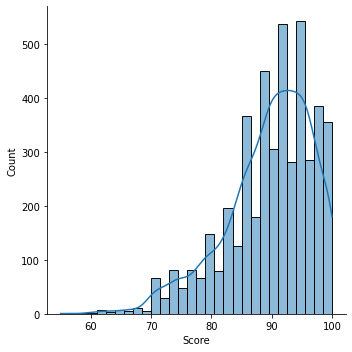

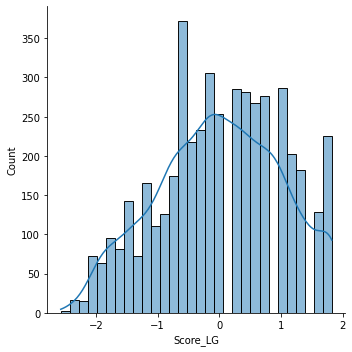

In [371]:
# checking distribution before scaling

plt.figure(figsize = (12,12));

sns.displot(data = X_train, x = 'Score', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'Score_LG', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);

#plt.title("Scores", size = 12);

In [372]:
numerics_trimmed.is_open.value_counts(normalize = True)

1.0    0.868304
0.0    0.131696
Name: is_open, dtype: float64

<Figure size 864x864 with 0 Axes>

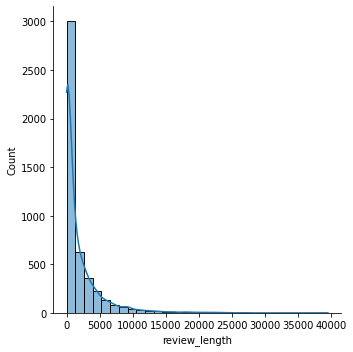

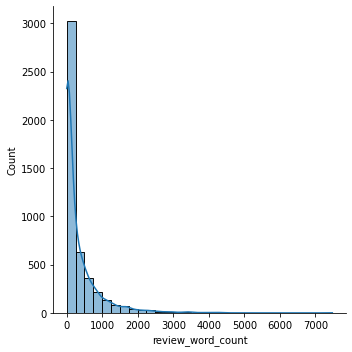

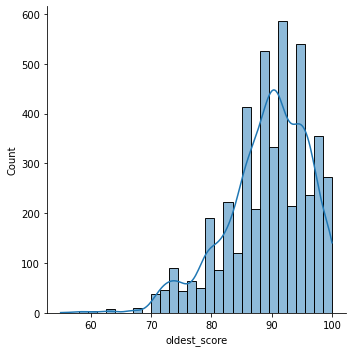

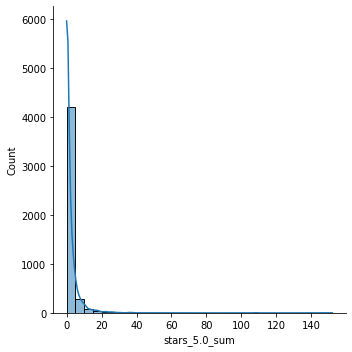

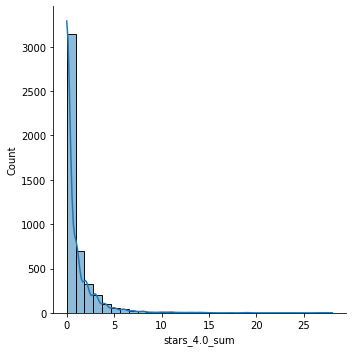

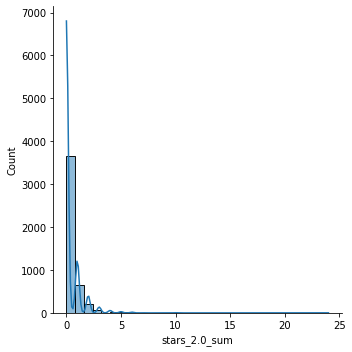

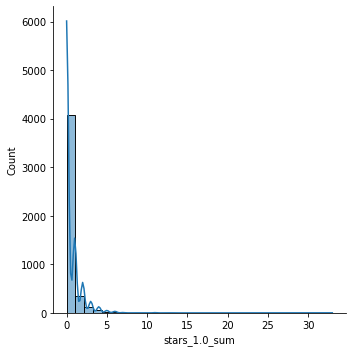

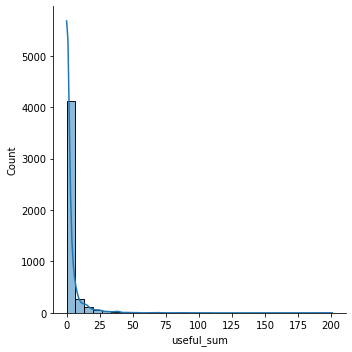

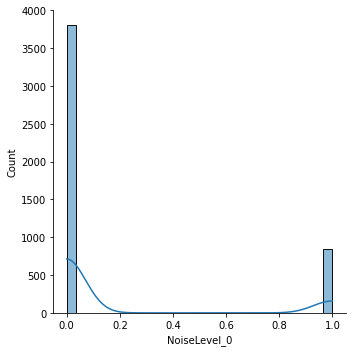

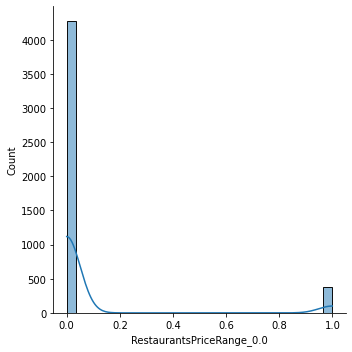

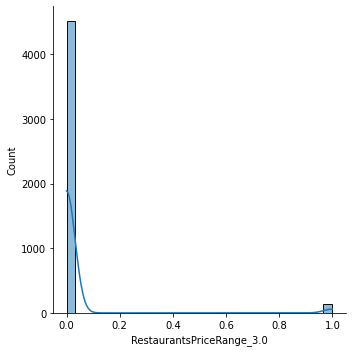

In [376]:
# checking distributions before scaling

plt.figure(figsize = (12,12));

sns.displot(data = X_train, x = 'review_length', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'review_word_count', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'oldest_score', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'stars_5.0_sum', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'stars_4.0_sum', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'stars_2.0_sum', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'stars_1.0_sum', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'useful_sum', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'NoiseLevel_0', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'RestaurantsPriceRange_0.0', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);
sns.displot(data = X_train, x = 'RestaurantsPriceRange_3.0', palette ='YlGnBu', kind = 'hist', bins = 30, kde = True);


#plt.title("Review Length", size = 12);

In [379]:
# scaling more columns

#numerics_trimmed_scaled = numerics_trimmed.copy()

cols_to_scale = ['review_length', 'review_word_count','oldest_score','newest_score', 'reviews_count', 'stars','useful_sum', 'stars_5.0_sum', 'cool_sum', 'RestaurantsPriceRange2','funny_sum', 'stars_4.0_sum','stars_1.0_sum', 'OutdoorSeating', 'lunch', 'Caters', 'Food','stars_3.0_sum',  'stars_2.0_sum']

for col in cols_to_scale:
    pow_trans = PowerTransformer()
    #pow_trans.fit_transfom(numerics_trimmed_scaled[[col]])
    X_train[col] = pow_trans.fit_transform(X_train[[col]])
    
X_train.head()

,review_length,review_word_count,Score,oldest_score,newest_score,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,is_open,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,Food,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_0.0,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0,Score_LG
4153,0.736013,0.754780,97.0,0.140290,-1.703757,0.240641,-1.417085,0.484796,-0.906319,-0.674029,0.798675,-0.609501,1.0,1.0,1,1.0,1.0,-0.686507,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.378834,-1.064080,1.023676,-0.923301,1.099116,1.755735,1,0,0.0,0,0.0,-0.526337,0.0,0.0,1,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,1.0,0,0,1,0,1.156159
2528,1.316390,1.363616,84.0,-1.432572,-0.471228,1.572180,0.575043,1.540975,1.531164,1.769665,0.798675,1.851707,1.0,1.0,1,1.0,1.0,1.736834,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,1.711147,-1.064080,-0.976872,-0.923301,-0.909822,1.885868,1,0,0.0,1,0.0,-0.526337,0.0,1.0,0,1.0,1.0,0.0,0.0,0,1,0.0,0.0,0,1.0,1.0,0,0,1,0,-0.907302
5064,-1.218868,-1.197880,93.0,0.674463,0.533732,-1.125629,-0.888073,-0.813030,-0.906319,-0.674029,0.798675,-0.609501,1.0,1.0,0,0.0,1.0,-0.686507,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,-0.660497,-1.064080,-0.976872,-0.923301,-0.909822,-0.550000,0,0,0.0,1,1.0,-0.526337,1.0,0.0,0,0.0,1.0,0.0,1.0,0,1,0.0,1.0,0,1.0,0.0,0,0,1,0,0.387093
4135,0.451817,0.382117,100.0,1.950778,0.073864,-0.201315,0.575043,-0.813030,0.397619,-0.674029,-2.036049,-0.609501,1.0,1.0,1,0.0,1.0,-0.686507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.660497,-1.064080,-0.976872,-0.923301,1.099116,-0.550000,0,0,0.0,0,0.0,-0.526337,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0,0,1.826447
723,1.481343,1.555772,92.0,0.311227,0.222107,1.895051,0.575043,1.620312,1.796199,1.717012,0.798675,1.786015,1.0,1.0,1,1.0,1.0,1.765510,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1.739766,0.939779,-0.976872,-0.923301,-0.909822,1.914771,0,1,1.0,0,0.0,1.952144,1.0,0.0,0,1.0,1.0,1.0,0.0,1,0,0.0,0.0,0,0.0,0.0,0,0,1,0,0.215188


In [380]:
X_train = X_train.drop(columns = ['Score'])
X_train.head(1)

,review_length,review_word_count,oldest_score,newest_score,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,is_open,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,Food,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_0.0,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0,Score_LG
4153,0.736013,0.75478,0.14029,-1.703757,0.240641,-1.417085,0.484796,-0.906319,-0.674029,0.798675,-0.609501,1.0,1.0,1,1.0,1.0,-0.686507,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.378834,-1.06408,1.023676,-0.923301,1.099116,1.755735,1,0,0.0,0,0.0,-0.526337,0.0,0.0,1,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,1.0,0,0,1,0,1.156159


In [ ]:
> double check drops
> make scaled and unscaled version of df